In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.transforms import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def readAndPreprocess(img_path):
    # Read and convert from BGR to RGB
    img = cv2.imread(img_path)[..., ::-1]
    # Resize
    img = cv2.resize(img, (224, 224))
    # Convert to tensor, normalize and flatten 
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # From ImageNet 
    ])
    img = transform(img).unsqueeze_(0)
    return img

In [10]:
input_img = readAndPreprocess("../images/lena.png")

tensor([[[[ 1.7523,  1.7009,  1.7523,  ...,  1.7865,  1.8893,  1.5297],
          [ 1.7523,  1.7009,  1.7523,  ...,  1.7865,  1.8893,  1.5297],
          [ 1.7694,  1.7009,  1.7865,  ...,  1.4954,  1.2385,  0.4337],
          ...,
          [-0.6109, -0.5082, -0.4568,  ...,  0.1254,  0.4508,  0.6221],
          [-0.6452, -0.5596, -0.4911,  ...,  0.3652,  0.7933,  0.7419],
          [-0.7137, -0.5253, -0.5253,  ...,  0.6221,  0.9132,  0.9988]],

         [[ 0.3627,  0.3452,  0.2577,  ...,  0.4678,  0.5728,  0.0476],
          [ 0.3627,  0.3452,  0.2577,  ...,  0.4678,  0.5728,  0.0476],
          [ 0.3803,  0.2577,  0.2927,  ..., -0.0224, -0.3025, -1.0378],
          ...,
          [-1.5980, -1.5105, -1.5280,  ..., -1.2829, -0.8803, -1.0028],
          [-1.6331, -1.5805, -1.6331,  ..., -1.0028, -0.8452, -0.8978],
          [-1.6506, -1.5455, -1.6506,  ..., -0.8627, -0.8803, -0.7752]],

         [[ 0.3742,  0.4265,  0.2348,  ...,  0.4439,  0.3393, -0.0092],
          [ 0.3742,  0.4265,  

In [4]:
def forward_img(model, x, layer_max_count):
    deconv_layers_list = []
    unpool_layers_list = []

    layer_count = 0

    for layer in model.features:
        if isinstance(layer, torch.nn.Conv2d):
            B, C, H, W = x.shape
            x = layer(x)
            deconv_layer = nn.ConvTranspose2d(layer.out_channels, C, layer.kernel_size, layer.stride, layer.padding)
            deconv_layer.weight = layer.weight
            deconv_layers_list.append(deconv_layer)

        if isinstance(layer, torch.nn.ReLU):
            x = layer(x)
            deconv_layers_list.append(layer)

        if isinstance(layer, torch.nn.MaxPool2d):
            x, index = layer(x)
            unpool_layers_list.append(index)
            unpool_layer = torch.nn.MaxUnpool2d(kernel_size=layer.kernel_size, stride=layer.stride,
                                                padding=layer.padding)
            deconv_layers_list.append(unpool_layer)

        layer_count += 1
        if layer_max_count == layer_count:
            break

    return x, deconv_layers_list, unpool_layers_list

In [5]:
def backward_feature_maps(y, deconv_layers_list, unpool_layers_list):
    for layer in reversed(deconv_layers_list):
        if isinstance(layer, nn.MaxUnpool2d):
            y = layer(y, unpool_layers_list.pop())
        else:
            y = layer(y)

    return y

In [7]:
def visualize(layer_max_count, img):
    npimg = img[0].data.numpy()
    npimg = ((npimg - npimg.min()) * 255 / (npimg.max() - npimg.min())).astype('uint8')
    npimg = np.transpose(npimg, (1, 2, 0))
    path = "../results/" + str(layer_max_count) + "th-layer.png"

    plt.imshow(npimg)
    plt.show()
    plt.imsave(path, npimg)


layer...4


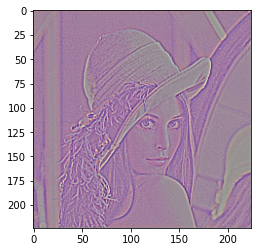

layer...9


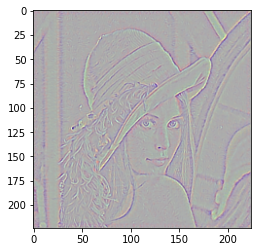

layer...16


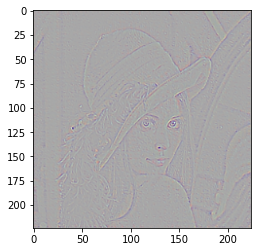

layer...23


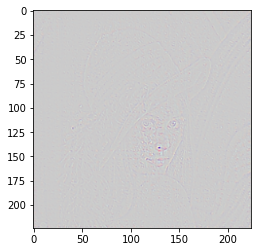

layer...30


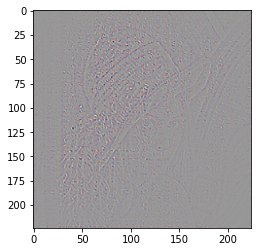

In [8]:
input_img = readAndPreprocess("../images/lena.png")

model = models.vgg16(pretrained=True).eval()
visualize_layer_indices = []

for i, layer in enumerate(model.features):
    if isinstance(layer, torch.nn.MaxPool2d):
        layer.return_indices = True
        visualize_layer_indices.append(i)

for layer_max_count in visualize_layer_indices:
    print("layer...%s" % layer_max_count)
    raw_feature_maps, deconv_layers_list, unpool_layers_list = forward_img(model, input_img, layer_max_count)
    reproducted_img = backward_feature_maps(raw_feature_maps, deconv_layers_list, unpool_layers_list)
    visualize(layer_max_count, reproducted_img)